In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load data
df = pd.read_csv("shiller.csv")
print(df)

        date      cape  mkt5yrfwd
0     1950-1  10.52932   0.232356
1     1950-2  10.74572   0.231242
2     1950-3  10.91136   0.234058
3     1950-4  10.91094   0.229607
4     1950-5  11.17801   0.230596
..       ...       ...        ...
883   2023-8  30.89186        NaN
884   2023-9  30.30442        NaN
885  2023-10  29.79968        NaN
886  2023-11  28.76921        NaN
887  2023-12  30.01311        NaN

[888 rows x 3 columns]


In [95]:
# Convert date into datetime format
df['date'] = pd.to_datetime(df['date'])
# Keep post-1950 period
df = df[df['date'].dt.year >= 1950]
print(df)

          date      cape  mkt5yrfwd
0   1950-01-01  10.52932   0.232356
1   1950-02-01  10.74572   0.231242
2   1950-03-01  10.91136   0.234058
3   1950-04-01  10.91094   0.229607
4   1950-05-01  11.17801   0.230596
..         ...       ...        ...
883 2023-08-01  30.89186        NaN
884 2023-09-01  30.30442        NaN
885 2023-10-01  29.79968        NaN
886 2023-11-01  28.76921        NaN
887 2023-12-01  30.01311        NaN

[888 rows x 3 columns]


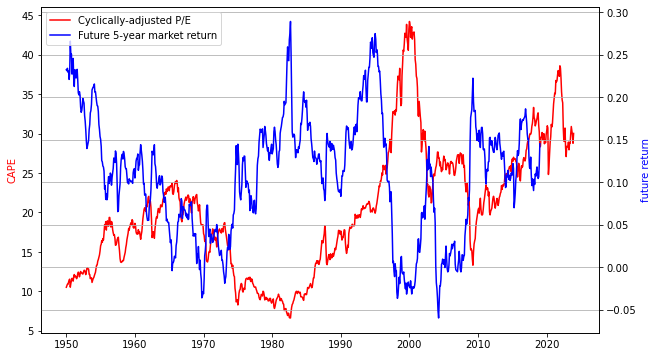

In [101]:
# Plot CAPE and future returns
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: CAPE
ax1.plot(df['date'], df['cape'], color='r', label='Cyclically-adjusted P/E')
ax1.set_ylabel('CAPE', color='r')

# Right axis: future return
ax2 = ax1.twinx()
ax2.plot(df['date'], df['mkt5yrfwd'], color='b', label='Future 5-year market return')
ax2.set_ylabel('future return', color='b')

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.show()

In [97]:
# Estimate linear model over 1950-1989

# Select period 1950-1989
df_5089 = df[df['date'].dt.year <= 1989]

# Estimate OLS
X = df_5089['cape']
y = df_5089['mkt5yrfwd']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Result
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              mkt5yrfwd   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     410.5
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           2.42e-66
Time:                        13:01:59   Log-Likelihood:                 799.13
No. Observations:                 480   AIC:                            -1594.
Df Residuals:                     478   BIC:                            -1586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2517      0.007     35.131      0.0

In [98]:
# OLS estimates of standard errors are biased because the 10-year future return window overlaps across monthly observations.
# We need to Heteroskedasticity and Autocorrelation Consistent (HAC) standard errors.
robust_se_model = model.get_robustcov_results(cov_type='HAC', maxlags=60)
print(robust_se_model.summary())

                            OLS Regression Results                            
Dep. Variable:              mkt5yrfwd   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     29.22
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           1.02e-07
Time:                        13:02:02   Log-Likelihood:                 799.13
No. Observations:                 480   AIC:                            -1594.
Df Residuals:                     478   BIC:                            -1586.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2517      0.031      8.113      0.0

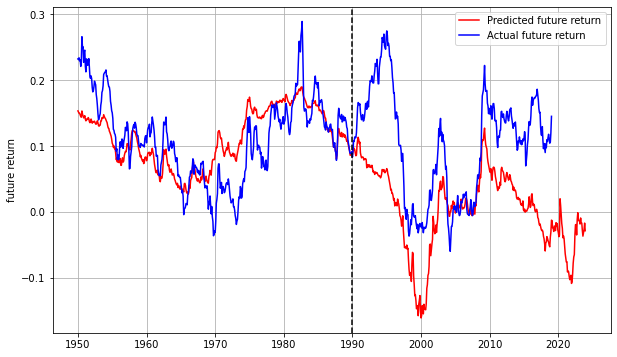

In [104]:
# Future return predicted by the linear model
X_full = df['cape']
X_full = sm.add_constant(X_full)
df['mkt5yrfwd_pred'] = model.predict(X_full)

# Plot predicted and actual future return
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['mkt5yrfwd_pred'], color='r', label='Predicted future return')
plt.plot(df['date'], df['mkt5yrfwd'], color='b', label='Actual future return')
plt.axvline(pd.to_datetime('1990-01-01'), color='black', linestyle='--')
plt.ylabel('future return')
plt.legend()
plt.grid(True)
plt.show()